# Setup

In [1]:
import Pkg

In [234]:
Pkg.add("Plots")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Workspace/Repo/Code/SpinGlassExhaustive.jl/Project.toml`
  No Changes to `~/Workspace/Repo/Code/SpinGlassExhaustive.jl/Manifest.toml`


In [235]:
using Random
using Distributions
using CUDA
using BenchmarkTools
using BinomialGPU
using StaticArrays
using Setfield
using Plots

In [7]:
N = 10

10

# Chunk mapping

In [8]:
blocks = 3
threads = 4

for i in 1:threads
    for j in 1:blocks
        idx = (i - 1)*blocks + j
        println(idx)
    end
end

1
2
3
4
5
6
7
8
9
10
11
12


In [5]:
blocks = 3

threads = 4

function check_map!(x)
    idx = (blockIdx().x - 1) * blockDim().x + threadIdx().x 
    x[idx] = idx
    
    return
end

x = zeros(Int32, blocks*threads) |> cu 

@cuda threads=threads blocks=blocks check_map!(x)

x

12-element CuArray{Int32, 1}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12

## Algorithm

In [3]:
N = 16

# graph = zeros(2^N)
graph = rand(Uniform(-5,5),N, N)
graph = graph * graph'

graph_dict = Dict()
for i in 1:N
    graph_dict[(i, i)] = graph[i,i] #rand(Uniform(-5,5))
    for j in i:N
        graph_dict[(i, j)] = graph[i,j] #rand(Uniform(-5,5))
    end
end

qubo = zeros(N,N)
constant = 0

for i in 1:N
    qubo[i,i] = 2 * graph[i,i]
    constant += graph[i,i]
    
    for j in 1:N
        if i!=j
            low, high = sort!([i, j])
            constant -= graph[low,high]*0.5
            qubo[i,i] -= 2*graph[low,high]
            qubo[low,high] += graph[low,high]*2
        end
    end
end

#############

qubo_dict = Dict()
constant = 0

for k in keys(graph_dict)
   qubo_dict[k] = 0 
end

for i in 1:N
    qubo_dict[(i,i)] = 2 * graph_dict[(i,i)]
    constant += graph_dict[(i,i)]
    
    for j in 1:N
        if i!=j
            low, high = sort!([i, j])
            constant -= graph_dict[(low,high)]*0.5
            qubo_dict[(i,i)] -= 2*graph_dict[(low,high)]
            qubo_dict[(low,high)] += graph_dict[(low,high)]*2
        end
    end
end

cu_graph = graph |> cu 
cu_qubo = qubo |> cu 

16×16 CuArray{Float32, 2}:
 48.1682  -40.807   237.422    19.4463  …   -69.4655     24.7035   299.017
  0.0     410.995  -161.758  -199.389      -209.926      16.1406   151.078
  0.0       0.0     331.62    100.275        37.175     -33.3078    50.3297
  0.0       0.0       0.0     402.693       163.803    -362.886     64.5762
  0.0       0.0       0.0       0.0          -7.69596   109.609     59.0339
  0.0       0.0       0.0       0.0     …  -127.735      82.7092   177.97
  0.0       0.0       0.0       0.0         221.722    -336.347    383.698
  0.0       0.0       0.0       0.0        -262.229      80.6109   203.22
  0.0       0.0       0.0       0.0          55.1655     49.8914   -65.6049
  0.0       0.0       0.0       0.0          30.2949    156.289    -69.5706
  0.0       0.0       0.0       0.0     …   186.668     -98.8778   -23.6883
  0.0       0.0       0.0       0.0         184.828    -261.243     41.4521
  0.0       0.0       0.0       0.0         340.976     123.616    3

In [14]:
res = Vector{Float64}()
#     res = Dict()

for (k, q) in enumerate(Iterators.product(fill(0:1,N)...))
    F = 0
    for i in 1:N
        F -= qubo[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= qubo[low,high]*q[i]*q[j]
        end
    end
    append!(res, F) 
#         res[k] = F
end

print(res)

[0.0, -837.7963459019106, 113.81649215770713, -797.9767151250353, -949.3832969624182, -2062.6439717554335, -1101.3096227319209, -2288.567158905768, -702.1932935416166, -1469.0128702653888, -776.7733591499335, -1617.5897972545374, -1318.7574489502585, -2361.041354565135, -1659.0803324857852, -2775.3610994814935, -622.9922367659066, -1103.554387152244, -965.5105068043306, -1520.0695185714999, -1375.7110232723405, -2131.7375025497827, -1983.9721112379743, -2813.995451896249, -1374.952242282554, -1784.537623490753, -1905.8670700870018, -2389.4493126760326, -1794.8518872352117, -2479.9015973345154, -2591.5095329668698, -3350.556104447006, -633.7577372818887, -1544.501817104171, -279.7123704963063, -1264.4533116994207, -1436.04895439049, -2622.2573631038767, -1347.7464055321173, -2607.9516756263356, -1347.4596348155978, -2187.2269454597417, -1181.8108257960394, -2095.574997821015, -1816.931710370423, -2932.163349905671, -1917.0257192780743, -3106.254220194154, -1126.5389265786798, -1680.0488

, -3909.5182138354285, -3889.451820750207, -4631.883600783226, -2944.484433576318, -3266.478254159266, -3515.5066989821, -3911.497380945879, -3285.4128825120506, -3882.871031986102, -4122.177965845042, -4793.632976699923, -317.69410175265193, -1165.6981940399544, -550.1656562734925, -1472.1666099416268, -1392.4393115967498, -2515.9077327751575, -1890.6536840448005, -3088.11896660404, -809.1688264983827, -1586.1961496075469, -1230.0369387852472, -2081.061123275243, -1551.0948947887046, -2603.5865467889726, -2237.7058250027785, -3364.194338383879, -1226.5662131945387, -1717.3361099662684, -1915.3725299115104, -2480.1392880640715, -2104.6469125826525, -2870.881138245486, -3059.196047226834, -3899.4271342705006, -1767.8076499153003, -2187.600777508891, -2645.0105243982953, -3138.8005133727183, -2313.069207749638, -3008.3266642343333, -3456.014900159843, -4225.269218025371, -800.6094611631152, -1721.5612873707894, -792.8521410560804, -1787.8008286445865, -1728.262591153396, -2924.6787462521

 -3279.306961119134, -4244.207052494146, -4006.025328934542, -5044.922281690386, -2960.8873983909916, -3364.0657345374684, -3689.8011527092976, -4166.976350236605, -3759.9969017621806, -4438.639566799759, -4754.653474007692, -5507.293000426103, -3127.317558477692, -3459.5191254460324, -4044.6278705620225, -4450.826298911192, -3593.607920295105, -4201.273816154548, -4776.661050306642, -5458.323807546914, -424.9254891438193, -1261.9011574013189, -795.4217842870318, -1706.3943139253633, -1507.9711923707264, -2620.4111895193305, -2144.2103054411486, -3330.647163970585, -1389.2955554022078, -2155.2944544815687, -1948.1884083114442, -2788.184168771637, -2139.5221170753384, -3180.9853450458045, -2964.157787911785, -4079.6178772630833, -1230.4819092908215, -1710.2233820327483, -2057.3129666301647, -2611.0513007529235, -2116.863102061744, -2872.068903694776, -3209.4369773282983, -4038.639640342162, -2244.61868752424, -2653.383391088029, -3259.846302629609, -3742.6078675742287, -2798.18073874138

, -3953.2975110695565, -3723.387316521914, -4748.235753045265, -4399.73386719367, -5498.579165097852, -3308.8715989362604, -3987.2789373903693, -3907.8718894468307, -4660.276089281771, -3980.126964592465, -4933.998631937678, -4844.870073030246, -5872.738601756291, -3077.1958756739723, -3469.345787790645, -3944.134370614649, -4410.281144112154, -3884.6058724279687, -4552.2201134357465, -5017.287185295856, -5758.898287684466, -3716.5213772733305, -4037.694520211866, -4771.856429980032, -5167.0264342994, -4191.112232473551, -4787.749704303192, -5512.190103107462, -6182.824436317935, -448.51769687149124, -1295.7011115143828, -1165.3020386932512, -2086.482314716975, -1656.9253129800777, -2779.5730565140743, -2639.4524727290486, -3836.0970776438767, -1202.1691943339938, -1978.3758397987467, -2107.350093921778, -2957.5536007673627, -2077.757668888804, -3129.428643244662, -3248.681386403798, -4374.349222140489, -1539.9539916944736, -2029.903210821792, -2713.0730957123656, -3277.0191762205154, 

 -4177.430372528265, -4711.327856822927, -6085.025164468597, -6692.919510144091, -2532.8827343082326, -3292.4745883258715, -3289.7745137313264, -4123.363229129796, -3662.3191543998937, -4697.375337308634, -4684.953751750197, -5794.00679603977, -2911.722955136675, -3600.338039976176, -3857.0112923257925, -4619.623238546124, -3708.3402336745594, -4672.4196474051605, -4919.371388790887, -5957.447663902322, -3176.6456753462526, -3579.003333848318, -4389.8722169654775, -4866.226736848374, -4109.417584981929, -4787.239572375099, -5588.386944528363, -6340.205793302365, -3605.2526081497253, -3936.6334974736537, -5006.875707534974, -5412.253458239731, -4205.205376231626, -4812.050594446656, -5872.5712935440815, -6553.413373139948, -1673.8454564509464, -2712.842741939346, -1115.2881771165223, -2228.282323985754, -2603.066607825395, -3917.5282222048995, -2310.2521464181805, -3698.710622178517, -2136.0068110086436, -3104.027327318905, -1765.8460894402438, -2807.8634671313366, -2732.408820829316, -

 -4071.1760733547026, -4867.864197673009, -4515.032686372828, -5385.717672071967, -3396.1067345059228, -3846.353760754986, -3762.6170873628616, -4286.860974992758, -3863.965117707501, -4589.67647284767, -4496.218288491651, -5295.926505012652, -3419.6999731601036, -4371.1056980232515, -2901.250131427013, -3926.6527176709924, -4269.949928517627, -5496.819982271877, -4017.2429047117466, -5318.109819846829, -3507.050051083742, -4387.47900676875, -3176.996767116675, -4131.4225841825155, -4024.4808648874878, -5180.374149463601, -3960.170398847631, -5190.060544804575, -3771.0706122214133, -4365.242141568987, -3708.955532684454, -4377.12392341286, -4424.656057122953, -5294.291915361629, -4628.283795513202, -5571.916515132712, -3908.187402120082, -4431.3821622895175, -4034.4688803491463, -4631.660501899414, -4228.953705467844, -5027.612794528383, -4620.9780016241175, -5493.633952065488, -2093.818362876131, -3143.0233947499228, -1881.5491302202545, -3004.751023474878, -3148.4014271322594, -4473.

, -5494.074188997592, -3917.171424840564, -4448.602966653159, -4441.573266610027, -5047.001669803453, -4843.210862477598, -5650.106733181297, -5633.355522174271, -6514.248254258803, -3832.061041951254, -4292.515814585709, -4544.85944148674, -5079.31107550203, -4425.2813380345115, -5161.200439560073, -5403.82255549721, -6213.738518403602, -3629.650596853917, -4591.264068102455, -3457.4888017993726, -4493.099134428744, -4605.262465093119, -5842.3402652327595, -4698.843487965784, -6009.918149486259, -3506.282105981668, -4396.918808052068, -3522.5168686931493, -4487.150432144382, -4149.074832667094, -5315.175863628599, -4431.052413305783, -5671.15030564812, -4266.901110591205, -4871.280386324172, -4551.074077732795, -5229.450214846591, -5045.848468374424, -5925.692072998493, -5595.76425344322, -6549.604719448122, -4193.299331693987, -4726.701838248816, -4665.8688566016, -5273.268224537259, -4639.427547923429, -5448.294383369362, -5377.73989075825, -6260.603587585012, -1836.5238771415197, -

, -4683.765941292449, -4206.805457751713, -5288.930330763044, -4867.036653640652, -6023.158388032814, -3734.747781092866, -4255.150898875657, -4397.174363484701, -4991.574342648324, -4669.087712112709, -5464.955158786604, -5597.257112431756, -6467.121420486485, -4122.532739716214, -4571.959088320867, -4973.355879874072, -5496.779089859559, -4724.05352918228, -5448.944206678038, -5840.61948726735, -6639.50702614394, -3484.7488923060037, -4435.3339395247385, -3450.611837873832, -4475.1937464734, -4468.661253928015, -5694.710630037855, -4700.267017423053, -6000.313254913725, -3834.275742946412, -4713.88402098701, -3988.5352462802657, -4942.140385701695, -4485.368963014647, -5640.441569946352, -4905.37128427571, -6134.440752588243, -4018.6837147484084, -4612.034566451571, -4440.88142251237, -5108.2291355963625, -4805.931565914435, -5674.746746508703, -5493.8720916056045, -6436.684133580704, -4417.977277363848, -4940.351359888873, -5028.571542893832, -5624.9424867996895, -4872.405986976098,

 -3264.5926965740327, -4081.460987079651, -4005.3691212143094, -4896.234273100759, -4188.1399093777645, -5280.472528774487, -5194.659151945251, -6360.988632722804, -4087.318763309104, -4617.929627477285, -5096.033392379487, -5700.641117928501, -5147.020607210626, -5953.095800269916, -6421.478054208221, -7301.550108648339, -4264.385153136565, -4724.019248126609, -5461.496339972971, -5995.127296343849, -4991.267855484311, -5726.366279365463, -6454.121860247928, -7263.2171455099115, -3400.5976219748354, -4361.390415578963, -3712.748614221213, -4747.538269206171, -4509.871896478528, -5746.129018973759, -5087.765706652113, -6398.0196905281755, -3539.405903819358, -4429.221928245349, -4039.9534538317594, -5003.766339638581, -4315.861036769274, -5481.141390086368, -5082.151404708884, -6321.428619406808, -4220.4123190932205, -4823.970917181776, -4988.898073535729, -5666.453533005115, -5133.022083140927, -6012.045010120586, -6167.250655510646, -7120.270443871136, -4408.9873129127745, -4941.5691

, -5295.949403032209, -2880.897180957902, -3687.333408795988, -2789.3642950018507, -3669.79738422077, -3724.5201165569392, -4806.420673286131, -3898.730048528099, -5054.627466638121, -3245.0762461962354, -3980.535704856184, -3341.9399180062087, -4151.396238046989, -3755.8800402414968, -4766.80382779255, -4118.48652997868, -5203.407178910564, -2697.7625089208964, -3146.9645412434097, -3062.564385160977, -3585.763278864322, -3344.7209340639506, -4069.3872952775687, -3975.2656282312405, -4773.9288508256905, -3111.708286134261, -3489.9335492786363, -3664.9067201403655, -4117.128844665573, -3425.8475697235385, -4079.5371617590195, -4244.788821656852, -4972.475275073164, -3740.2464263361876, -4619.630388094645, -3408.4846657522617, -4361.865488891552, -4436.77728208141, -5591.625572730969, -4370.758339424692, -5599.603491455084, -4115.934095566614, -4924.341288146932, -3972.568892748712, -4854.972946709862, -4479.64580975806, -5563.517331229481, -4602.023424867368, -5759.8918077196195, -3426

 -4910.902435165641, -5549.812657177212, -4087.687682154123, -4928.065371675968, -5335.319555849936, -6249.694106752611, -3202.9933513684514, -4019.63732559193, -3457.748512090948, -4348.38934769526, -4171.978199849169, -5264.086502963752, -4692.476178498877, -5858.581342994288, -3356.4538478109002, -4102.121052856241, -3799.60556629942, -4619.269632725593, -3992.6195547378416, -5013.751088674286, -4701.514091153571, -5796.642486470844, -3305.738554007427, -3765.1483327153323, -4016.828476926055, -4550.235117014792, -4078.05889203216, -4812.93299963117, -5054.891632877996, -5863.762601857838, -3508.965762424906, -3897.3987719546735, -4408.452243109556, -4870.882114020156, -3948.4669588958627, -4612.364297316735, -5113.696257507721, -5851.590457309425, -3911.500218875313, -4801.0919270191625, -3926.026504969934, -4889.6150744946135, -4733.392987502211, -5898.4490245371635, -5013.662091524044, -6252.714989939825, -4076.4693193098524, -4895.084258275563, -4279.392163170498, -5172.00396351

 -3165.671449634636, -4065.9974843048167, -4362.931506186797, -5337.2544022378115, -3602.6742454897985, -4156.559182090737, -4722.588041880776, -5350.469839862546, -3769.6490416296956, -4598.998307121737, -5155.305655947881, -6058.651782820754, -2888.0461066601692, -3693.6616568538448, -3280.8260080050386, -4160.4384195795465, -3865.331448523696, -4946.411327608475, -4523.854167795775, -5678.930908261385, -3514.401944615275, -4249.040725630813, -4095.5784037261683, -4904.214046122537, -4158.868144925025, -5168.971254831666, -5005.7874219631285, -6089.887393250601, -2887.4756180042605, -3335.8569726823616, -3736.59028154526, -4258.9684976041935, -3668.0964494118025, -4391.94213298101, -4782.953930880012, -5580.796475830051, -3563.598167934396, -3941.00275343436, -4601.10938924142, -5052.510836122216, -4011.399857788162, -4664.268772179231, -5314.6538970223955, -6041.519672794297, -3530.7592220719316, -4409.3225061859775, -3683.3102487889246, -4635.870394283802, -4360.952484081641, -5514

 -4671.794143983178, -5942.582212757014, -3054.381184486653, -3689.4506366511223, -4332.186469790155, -5041.252783335454, -3679.537035062006, -4590.070816117579, -5223.085138292714, -6207.615780729118, -3780.4593492396025, -4344.552032225934, -5246.661192309126, -5884.7507366762875, -4072.7960582611795, -4912.353070138612, -5804.74071925791, -6718.294592516173, -2916.040383045739, -3731.8636796248074, -3655.1083310691565, -4544.928489029056, -4018.6876377909466, -5109.975263261118, -5023.4984037415725, -6188.782890592574, -3331.6776522049595, -4076.524179605889, -4259.1421579944, -5077.985546776161, -4101.5057653963895, -5121.816621688424, -5294.71308911304, -6389.020806785904, -3201.3497690658105, -3659.9388701293046, -4396.752479285357, -4929.338441729684, -4107.332513355033, -4841.385943309631, -5568.4780415017885, -6376.528332837219, -3666.7537502000605, -4054.3660820854166, -5050.553018185632, -5512.1622114518195, -4239.917352935507, -4902.994013711968, -5889.459438848286, -6626.5

 -3763.8712756562404, -4951.008886384483, -4239.160570682452, -5627.765648920968, -4239.428848326872, -5702.03078794622, -4175.641815648762, -5002.525138658741, -4178.105479796079, -5078.98566418689, -4521.611201489975, -5623.958853391059, -4789.817683564503, -5966.162196846417, -4610.229837496907, -5366.136391328746, -4801.0900594102495, -5630.993474622919, -4623.380081784346, -5654.750964507288, -5079.983121624897, -6185.350865728671, -3606.978302529746, -4614.615469954322, -3070.7046293969784, -4152.338658202387, -4430.439092540815, -5713.540588856495, -4159.908237335258, -5517.006595031769, -3731.1254287841607, -4667.785827030599, -3383.2483134174167, -4393.905573044687, -4221.767077241453, -5433.8918043789945, -4139.632779801919, -5425.754368320293, -3599.895386573106, -4250.298358482109, -3519.9564756364693, -4244.356308926304, -4226.69166612819, -5152.558966928298, -4412.495573118764, -5412.359735299702, -3773.809224802552, -4353.235427533416, -3882.266871631938, -4535.689935743

, -5440.980239443168, -4398.445250106124, -5595.790607219758, -4652.808411335467, -6051.621235959376, -4999.364735658433, -6472.174421663174, -4960.526186891964, -5797.617256287334, -5309.27789771783, -6220.365828494032, -5431.857485614859, -6544.412883901332, -6046.3520143679325, -7232.904274035238, -5184.395639944223, -5950.509940161455, -5721.543908536112, -6561.655070134175, -5322.907797113341, -6364.486426221676, -6125.79888363244, -7241.374374121604, -4031.353277612828, -5049.198191422796, -3841.3676511586077, -4933.209426349407, -4980.175980505577, -6273.48522320665, -5055.933171978568, -6423.239276060471, -3944.7818350713565, -4891.649979703187, -3943.1927663831607, -4964.057772395823, -4560.785396410329, -5783.117869933263, -4824.939145649343, -6121.268480553108, -4310.150236332169, -4970.760954626563, -4576.499372074079, -5311.106951749307, -5062.308428768933, -5998.383475954432, -5594.4003824380525, -6604.472291004384, -4273.345505765728, -4862.979454881985, -4728.0911992736

 -4055.5651551233514, -5588.323186276424, -3730.0824279722347, -4842.402499675234, -3948.920674990365, -5135.237608074196, -4073.559588980146, -5461.343989574249, -4558.140653925484, -6019.921915900421, -3796.765838346292, -4622.828483711857, -4283.542289794527, -5183.601796540926, -4276.397630451994, -5377.9246047086635, -5028.91689982744, -6204.440735464943, -4493.530632911207, -5248.616509098636, -5168.703642125469, -5997.786379693727, -4640.343283463135, -5670.893488541666, -5581.259110604604, -6685.806177063967, -3351.880159778768, -4358.696649558932, -3299.91927394692, -4380.732625107917, -4309.003356054324, -5591.284174725593, -4522.7852881496865, -5879.062968201788, -3738.204058749955, -4674.0437793519795, -3874.639730684131, -4884.4763126669895, -4362.508113471736, -5573.812162964865, -4764.686603333119, -6049.987514207083, -3527.3614272032246, -4176.9437214678155, -3931.735303567507, -4655.314459212928, -4287.820113022796, -5212.866736178492, -4957.936807314287, -5956.9802918

 -4089.645163367959, -5558.614079525592, -4732.117717225819, -6275.083494764287, -3724.26646171859, -4846.7942798069835, -4289.392755415268, -5485.917434884492, -4193.1055356081815, -5591.097682587677, -5023.974647232068, -6495.9636555923935, -4287.548315564513, -5123.818707315471, -5120.612813691298, -6030.880066823087, -4892.542020551895, -6004.276741193957, -5991.349336605888, -7177.0809186287825, -4773.594541333543, -5538.888163906364, -5795.055597226352, -6634.346081180003, -5045.769104767151, -6086.5270562310725, -6332.972978587166, -7447.72779143192, -3482.1532408368703, -4499.177477002427, -3776.4804016835697, -4867.501499229958, -4564.638349994106, -5857.126915050769, -5124.708328768014, -6491.193755205508, -3657.758571012171, -4603.806037999588, -4140.482289624894, -5160.526617993144, -4407.424538615632, -5628.936334494152, -5155.891075155563, -6451.399732414917, -3943.5143829373073, -4603.304423587289, -4694.176305980134, -5427.963208010951, -4829.334981638558, -5764.5893511

, -4846.708419027634, -3421.0429660503514, -3838.8094361861704, -5080.82194139199, -5572.585272908641, -1904.887970356855, -2548.3488102156534, -2413.963933181256, -3131.4216344208853, -2471.9492495754903, -3390.874418325393, -3246.7680303271004, -4239.690060457834, -2430.1675634763424, -3002.6516341570014, -3127.640084066767, -3774.1210161282575, -2664.409701141201, -3512.3581007129637, -3627.6250396588357, -4549.570300611429, -3090.7974485977547, -3377.0240929409792, -4056.2081736182854, -4416.431679342341, -3461.1942173604048, -4022.885190594733, -4692.347760308146, -5328.035594923306, -3665.843753692271, -3881.0936288573566, -4819.651036478826, -5108.8977730247425, -3703.421380901146, -4194.1355849573365, -5122.97148161491, -5687.682547051929, -2410.281992490487, -2877.262481248311, -2836.955380230934, -3377.9327303695886, -3258.1701654229923, -4000.61498307192, -3950.5863710906488, -4767.028050120408, -2674.887401991275, -3070.891121570959, -3289.957347497745, -3759.9579284582624,

, -5657.194555730241, -4450.634152712357, -4949.585138411706, -6268.304616966518, -6841.2524640467, -4160.602523520749, -4313.112411150854, -5900.926727613724, -6127.43347662466, -4470.6341434651185, -4898.60835998633, -6476.701165485304, -6978.6722433873465, -2603.113551138423, -3256.782137382613, -3458.4775606413714, -4186.143008266394, -3295.5367432387393, -4224.669658374033, -4416.643570668895, -5419.7733471850215, -2917.674575462024, -3500.366392528076, -3961.435142730997, -4618.123821177878, -3277.2786260085636, -4135.434771965717, -4586.782011204746, -5518.93501854273, -4074.902904055302, -4371.33729478392, -5386.601675754381, -5757.03292786383, -4570.661585699634, -5142.560305319353, -6148.1031753259185, -6793.99875632647, -4439.230640353934, -4664.688261904412, -5939.325969819034, -6238.780452750343, -4602.170180444488, -5103.092130886069, -6368.0083278367965, -6942.92713965921, -3033.878051787916, -3511.066286931131, -3806.8394862069094, -4358.024582730956, -4007.128137602101

 -4938.643533731613, -5786.820383119427, -3458.626856748965, -3671.085089527406, -5148.57924369829, -5435.0343378575635, -4109.778111629921, -4597.700673299467, -6065.473316506455, -6627.3927395568335, -4284.3413305681615, -4425.8227941684645, -6162.690275283509, -6378.168600264645, -4602.67344389534, -5019.619236386748, -6746.7652065379, -7237.707860410138, -2291.4789558729644, -2934.119118087352, -3284.8677059982856, -4001.5047295935046, -2992.202641356089, -3910.30713246158, -4251.334209408618, -5243.435561894942, -3078.935321709224, -3650.5987147454707, -4260.720629600568, -4906.380884017646, -3446.8398656385707, -4293.967587565922, -4894.367991457124, -5815.492574765307, -3659.9526174949597, -3945.358584193773, -5109.676129816408, -5469.078957896055, -4164.011792522098, -4724.882088112016, -5879.478122770758, -6514.3452797415075, -4497.175695306249, -4711.604892826922, -6135.295765393721, -6423.721824295228, -4668.415728779611, -5158.30925519139, -6572.278616794294, -7136.16900458

, -4604.051725283116, -3380.0336862102445, -4326.478517491447, -4190.057239945385, -5337.969538736859, -4104.229988700093, -5326.139148872398, -3849.5985318453118, -4435.789075408248, -3765.9666671029167, -4426.154072046685, -4444.206647505743, -5305.8615199597825, -4626.317600690557, -5561.96933452543, -4016.284443720742, -4531.498218105537, -4121.049136744369, -4710.259772509997, -4278.073417827394, -5068.751521103297, -4648.580928778232, -5513.255893434967, -4084.876555324322, -5101.249028323203, -3304.68105375792, -4395.0503881376335, -4729.057101586919, -6020.893903476905, -4214.6044179477285, -5580.4380812185445, -4213.304359216812, -5158.700063037554, -3621.505415416435, -4640.897980618008, -4524.665763925633, -5745.525796637478, -4198.609638052466, -5493.466532145144, -4189.5794842181695, -4848.717761701477, -3865.7187448478994, -4598.853883712038, -4637.095520024784, -5571.698126399196, -4578.977598581723, -5587.577066336966, -4367.774000085691, -4955.9355083908595, -4232.3098

 -5299.341363907689, -6602.435039643528, -4216.843218346876, -5099.498934632638, -4211.561195852921, -5168.213773519516, -4800.658615791193, -5958.778660968061, -5061.119411224447, -6293.236317782148, -4831.436438281307, -5427.834728229635, -5094.0926202174605, -5764.48777154662, -5551.406466823417, -6423.2690856628515, -6079.805466686778, -7025.664946907046, -4787.403781360849, -5312.825302131039, -5238.456521063024, -5837.874903214048, -5174.554668349184, -5975.440518010478, -5891.350225978569, -6766.232937020697, -4629.992209212913, -5656.572428597185, -4196.0847543250575, -5296.661835090163, -5399.534668357188, -6701.5792166325655, -5231.3700313965455, -6607.411441052753, -4547.701444309516, -5503.30489451565, -4302.190547187686, -5331.790858774652, -4984.424761900016, -6215.492540997255, -5004.656682705397, -6309.721323183468, -5020.5750127827405, -5689.921036651439, -5043.002320091018, -5786.345205340549, -5593.452961471033, -6538.263314230839, -5881.623086706519, -6900.430300847

, -5982.243339671822, -4974.26392763622, -6266.329179342257, -4218.335889582883, -5089.9631818388425, -4351.078607711301, -5296.702761348091, -4810.451780410009, -5957.543401557075, -5208.937316465637, -6430.025798993534, -4256.7180767097725, -4842.087942628297, -4657.398999268297, -5316.765726567654, -4984.988598634692, -5845.822793444321, -5651.412339120424, -6586.243395310889, -4685.580761301972, -5199.973858042359, -5274.658241626519, -5863.04819974774, -5081.032141673115, -5870.889567304607, -5935.8524399248745, -6799.706726937196, -4092.7957868411636, -5108.347582195633, -3796.913072575681, -4886.461729310982, -4870.638739368248, -6161.654863613824, -4840.498843029976, -6205.511828656383, -4483.400363450423, -5427.975389626756, -4375.914206950966, -5394.48609450813, -4928.424174423734, -6148.46352949117, -5086.680835851485, -6380.717052299756, -4380.0628991161075, -5038.380498955003, -4540.514947046757, -5272.829408266483, -4961.241341187209, -5895.023269917209, -5387.43620704506

 -5291.392999963332, -6519.669136673929, -5847.770024931483, -7150.043023022911, -4409.473458522033, -5291.308497163384, -4888.504223328997, -5844.336123351182, -5126.951262230838, -6284.250629763298, -5871.724844965014, -7103.021073878303, -4944.454089120789, -5540.031701424706, -5691.42305835786, -6360.997532042608, -5798.086523927387, -6669.1284651224105, -6810.798311091669, -7755.837113667524, -5162.598204917102, -5687.199048042881, -6097.963731920199, -6696.561436426809, -5683.411498169925, -6483.476670186808, -6884.51984310023, -7758.581876497947, -4343.809546704774, -5369.569088444635, -4394.214879117839, -5493.971282238534, -5247.014412113538, -6548.238282744505, -5563.162562453814, -6938.383294465613, -4523.69555451815, -5478.4783270798725, -4762.497444697238, -5791.277078639795, -5094.081278373138, -6324.328379825965, -5598.625986479438, -6902.869949313098, -4916.956533655698, -5585.481879879986, -5423.696628264894, -6166.218835870015, -5623.496888608479, -6567.486563723874, 

, -4559.574160326714, -3334.892638563531, -4280.292475918184, -4325.724710857005, -5472.592015721932, -4238.188982994854, -5459.053149240612, -4093.42797556008, -4893.854182355762, -3928.5459875367424, -4802.969055713255, -4398.162360510416, -5474.052896197202, -4499.023190414288, -5648.910587481908, -3258.3688021484263, -3772.5375826066743, -3361.425018555196, -3949.5906603942763, -3699.257818196556, -4488.890927545908, -4068.056852530535, -4931.686823260719, -3713.392305330644, -4156.584316610753, -4004.8450795034373, -4522.033952164379, -3821.462179824997, -4540.118519996211, -4378.657771924999, -5171.310973477045, -4386.929318481969, -5331.280028376162, -3793.4218980647324, -4811.769469339758, -4877.390765132264, -6097.205803917562, -4549.626162642239, -5843.438062808366, -4803.694713681248, -5677.068654397301, -4398.583851030035, -5345.954653126921, -4961.337018777768, -6110.175288384926, -4821.968974053765, -6044.804105041754, -3826.915888808387, -4414.032403187007, -3689.7432305

 -4277.887521258566, -5183.231958916146, -5263.77373512107, -6243.115034159481, -4345.43238495822, -5227.043107317433, -4338.441885847406, -5294.049469587451, -5108.347824344012, -6265.4228755943295, -5367.100143160409, -6598.172055791558, -4539.970607369521, -5350.604560550594, -4721.37666602473, -5606.007480586638, -4970.066905201536, -6056.165187273716, -5417.215781783957, -6577.310925236968, -4201.509877429734, -4725.886404273375, -4650.85414051505, -5249.227528739522, -4767.760806359543, -5567.601662094288, -5482.847887372069, -6356.685604487646, -4445.814811816066, -4899.214569481567, -5083.555632667406, -5610.95225171374, -4679.246599192098, -5408.110685748704, -5582.730237970648, -6385.591185908085, -4893.348141215873, -5847.906597495455, -4646.128767477182, -5674.684085137599, -5509.171500747847, -6739.194285918536, -5527.6949449363665, -6831.7145914878865, -5099.394967619263, -5982.976654720709, -5040.572151646598, -5998.150700128877, -5382.399185597463, -6541.445201590013, -

 -3606.64877586533, -4225.500460602004, -4464.816912422997, -5157.6654585405, -3567.554162910302, -4461.870176538078, -4691.465117395176, -5659.777992403787, -3638.190422426103, -4508.772720755512, -3769.224663937661, -4713.803823647902, -4409.406355194705, -5555.452982415218, -4806.183414633471, -6026.2269032348195, -4305.6239863500605, -5105.229515501332, -4625.054785627642, -5498.657176159745, -4744.020777564885, -5819.090635607262, -5329.194394769677, -6478.261114192887, -3390.952223602732, -3904.3003264165695, -3978.3212273104214, -4565.66619150509, -3965.5036459153503, -4754.316077620291, -4818.615467550248, -5681.424760636022, -4108.152499501721, -4550.5238331374185, -4883.918060975432, -5400.286255991962, -4349.8847802605615, -5067.720442787365, -5391.393159661483, -6183.22568356912, -4120.312426588655, -5063.842458838436, -4011.117793472338, -5028.64468710295, -4744.436279503439, -5963.430640644326, -4900.984464314331, -6193.97568683605, -4799.254594504703, -5671.807857576347,

, -4747.029989759845, -5053.331903965936, -6102.829294538078, -4119.598909809913, -4748.658340931976, -5324.055093046124, -6027.111385549021, -4205.866209736563, -5110.389969749732, -5676.065210899985, -6654.585832293987, -4001.3497290064506, -4882.139773721253, -4478.672017196557, -5433.45892329219, -4897.927574656732, -6054.181948262638, -5640.992680774047, -6871.243915760786, -4458.064724134521, -5267.877999671185, -5123.783570090652, -6007.593707008148, -5021.823428231028, -6107.101032658794, -5953.285092114368, -7112.5595579229675, -4039.99140485906, -4563.547254058289, -4973.648455245297, -5571.201165825356, -4739.904740053357, -5538.924918143692, -5939.304608366803, -6812.321647837969, -4546.473111962163, -4999.052191983253, -5668.526720114421, -6195.1026615163455, -4913.5673056026835, -5641.610714514879, -6301.363731682152, -7103.404001975182, -4332.629355297578, -5286.367133932749, -4569.722768859808, -5597.457408875814, -5082.115121094041, -6311.31722862032, -5584.95135258348

, -4907.635924901198, -4340.9709648069365, -5508.285364843754, -4347.431787048152, -5588.743048465802, -4676.736735877644, -5497.610037845218, -4605.851297957674, -5500.721461306081, -4483.817571070158, -5580.1552019288365, -4678.674951077398, -5849.009443316908, -4419.654986300885, -5492.258901861196, -3621.635653334806, -4768.236430275949, -5037.046367217029, -6385.114611668445, -4504.76985217816, -5926.834958010408, -4584.879838524152, -5586.506984906325, -3975.2570633240985, -5050.881071087101, -4869.452077886519, -6146.543553159797, -4525.572120613676, -5876.660457267783, -4165.9043601767835, -4881.274080221521, -3824.2197894068363, -4613.586370832405, -4586.631230636945, -5577.465279572785, -4510.689477794205, -5575.520388110881, -4380.895924375081, -5025.288875241681, -4227.6079113711585, -4945.997723618589, -4468.803653281466, -5388.660933039168, -4581.258458204752, -5575.112599343286, -5088.148196648994, -6233.699846129676, -4049.89998905504, -5269.448499916555, -5558.44749771

, -6223.17820702973, -5408.126440491182, -6384.181119403118, -5586.382279126597, -6763.904425548806, -5939.131148046359, -7190.6501558494, -5586.067568519738, -6417.148616872705, -5861.470177278315, -6766.548087012116, -5518.510316593933, -6625.055693838002, -6059.655743279719, -7240.19798190462, -5179.194991578745, -6262.006653524448, -4727.463705291215, -5884.272228617749, -5921.9482853765685, -7280.224276213376, -5735.959817016248, -7168.232669233888, -5133.701275006126, -6145.53616777369, -4870.366546484619, -5956.198300633015, -5543.635427250174, -6830.934648908843, -5546.0435166558755, -6907.33959969538, -5211.324240130624, -5936.901706560755, -5215.927716039225, -6015.502043850187, -5757.413023472464, -6758.454818793698, -6027.759317308271, -7102.79797401034, -5215.597235533036, -5870.197932785029, -5408.59726920766, -6137.194827840484, -5428.866877321101, -6358.931903464195, -5887.609728922932, -6891.671616446861, -5696.84582405543, -6852.605219921502, -5004.885663140022, -6234

 -3765.065323129118, -4656.094716630419, -3990.0961147440457, -4955.122369626177, -4038.627706139897, -5205.1214285323, -4529.401315682033, -5769.891899455268, -4502.907843662887, -5322.960467986049, -4916.335193043836, -5810.3846787478315, -4443.651085119889, -5539.1680383341545, -5122.821252428047, -6292.335067023146, -4107.427155920849, -5179.210393836747, -3793.72061025569, -4939.5007095524215, -4858.480943101481, -6205.728509908486, -4810.51721536353, -6231.761643551368, -4534.828780860888, -5535.6352495986475, -4409.518792961754, -5484.322123080346, -4953.063426487743, -6229.334224116609, -5093.496256515818, -6443.763915525516, -4036.240713177844, -4750.789755578169, -4178.868929708816, -4967.414833489973, -4590.6299899024925, -5580.643361193921, -4999.001024360672, -6063.011257032937, -4513.409050092914, -5156.981323315099, -4844.433824389908, -5562.002958992928, -4734.9791852637845, -5654.015787377078, -5331.746777487989, -6324.780240982115, -4559.284236302435, -5704.0152081387

 -5147.369529417751, -6684.3252859138165, -4591.012830542118, -5492.249970428811, -5162.33166883559, -6137.565670103117, -4989.937126434576, -6166.638595212373, -5826.998782655259, -7077.697112813888, -5118.13678228, -5948.397152988556, -5877.852178339498, -6782.109410428887, -5184.241936618682, -6289.9666362183425, -6209.70015060539, -7389.421711585878, -4572.86526717373, -5654.856251475019, -4605.446768187119, -5761.434613869242, -5449.280967236041, -6806.736280428437, -5747.605286176638, -7179.0574607498675, -4789.548323317882, -5800.562538441035, -5010.526382097295, -6095.5374586012795, -5333.144881826418, -6619.623425840676, -5819.865758533039, -7180.34116392813, -4787.558699106704, -5512.3154878924215, -5276.474962316222, -6075.228612482773, -5467.309888713032, -6467.531006389854, -6221.968969849759, -7296.186948907416, -5054.008467225887, -5707.788486833467, -5731.3212882014295, -6459.098169189842, -5400.940515278438, -6330.184863777123, -6343.996154181191, -7347.237364060708, -

 -2296.276403281201, -3474.8030102493994, -2128.7408284976914, -3508.7349029761626, -2566.7742605640856, -4020.765196423388, -1605.114986895108, -2423.3873061450395, -2045.3438054643984, -2937.612986095163, -1746.0246573485742, -2839.761305489611, -2451.9962938450753, -3619.729803366943, -2420.4717924525985, -3167.7673425243916, -3049.0971687879137, -3870.3895802405377, -2228.562321352288, -3251.322200315186, -3122.9305156148125, -4219.687255958543, -2174.647403120838, -3173.673566785368, -2076.138884410043, -3149.1619094554057, -2793.048477744159, -4067.538970299793, -2960.282776960574, -4308.77013089704, -2679.563313084598, -3607.612707570989, -2769.4513521398276, -3771.4976080070505, -2965.145246154142, -4168.658969531638, -3320.7761031365817, -4598.286687894909, -1883.1664689169006, -2524.958437065857, -2240.9927124022365, -2956.781541932026, -2304.903033084237, -3222.1593301242983, -2928.472094496783, -3919.725252917677, -2437.8490908556914, -3008.6642898265095, -2984.071892107051

 -1539.6212256405875, -2725.3354867914845, -1869.8033286922946, -3129.5144512240236, -2002.5573194317176, -3463.7359094737203, -2598.4822404106344, -4133.657691833469, -2094.492750427161, -3209.2302423999195, -2613.0714112448927, -3801.8057645984823, -2224.6097026645148, -3614.8115235283776, -3008.9311814094563, -4473.129863654148, -2072.220391652118, -2900.700457287442, -2858.7372568999563, -3761.2141839161122, -2338.491974987264, -3442.436369513692, -3390.7516581623136, -4568.692914069569, -2676.8586284137227, -3434.3619248709074, -3651.7720514275843, -4483.2722092655995, -2610.3110701950923, -3643.2786955433817, -3850.967311136164, -4957.931797865281, -2281.243411717728, -3290.4773217676498, -2529.0229396854807, -3612.253711116234, -3025.006399222728, -4309.704638163753, -3538.528745117691, -4897.223845439547, -2575.4407528856013, -3513.6978937573845, -3011.616838619379, -4023.8708408719936, -2986.3845988368257, -4200.106068599712, -3688.3035024978126, -4976.02183364153, -2275.64235

 -3518.659893839046, -4612.6249917961295, -2732.507413124148, -3406.034551631158, -4085.6744513882577, -4833.198451276097, -2821.3524281421437, -3770.343895540258, -4440.262284333461, -5463.250613112407, -1385.2450995889976, -2559.930936710092, -1853.4519432630764, -3102.1346417650034, -1856.481686762936, -3306.631852775136, -2590.4313483642263, -4114.578375757257, -2413.011965888229, -3516.7210338311847, -3069.615367328333, -4247.32129665212, -2551.429411508392, -3930.6028083424517, -3473.775630875706, -4926.945889090594, -1814.5285743056425, -2631.980215911164, -2739.0701801758546, -3630.5186831622073, -2089.100651023597, -3182.016621520224, -3279.3850748210193, -4446.2979066984735, -2892.0621525799056, -3638.537025007288, -4005.0003162161406, -4825.47205002435, -2833.8150877440844, -3855.754289062571, -4212.496069307528, -5308.432132006843, -2507.8388250828666, -3506.0443111029854, -2893.6430936729917, -3965.8454410739423, -3259.902305970676, -4533.572120881899, -3911.449392488011, 

 -3870.2282031243412, -5260.65847380425, -1990.328327445433, -2745.0399815159744, -3501.3868546220683, -4330.095370073438, -2537.354396898886, -3567.530379860531, -4314.155742002728, -5418.328586345203, -2845.6347329317177, -3529.36961782412, -4545.089817874373, -5302.821564147605, -3059.841660831393, -4019.0408746148987, -5025.039563701256, -6058.235638865595, -1272.3687356450469, -2457.262319151533, -2086.8636259976734, -3345.7540708849933, -1868.9672357006648, -3329.3251480982576, -2949.2049439805037, -4483.559717758923, -2089.4170331483915, -3203.33384747674, -3092.3084812670445, -4280.222156976222, -2353.196391650235, -3742.5775348696875, -3621.830657696097, -5085.208662296376, -1987.532085037672, -2815.1914730285866, -3258.361737586432, -4160.017986958177, -2387.4660746373083, -3490.589791519326, -3924.0385451132775, -5101.159123376122, -2854.34709451605, -3611.0297133288236, -4313.573304830832, -5144.252785024433, -2921.461942561908, -3953.608890265787, -4646.430970803897, -5752

, -4114.427856903237, -2849.4236072400954, -4156.203419874411, -3013.329879271275, -4521.577159415862, -3246.8513987888264, -4829.095540314246, -2920.577449928336, -3867.1029748443852, -3156.294355948785, -4176.816742245665, -3188.41705464765, -4410.406908454802, -3689.876778595308, -4985.863493783294, -3484.3937125098155, -4359.942468247724, -3908.507176296289, -4858.052793415029, -3419.414175675352, -4570.4272603043655, -4109.270457389035, -5334.2804033988805, -2832.223744161643, -4208.931198513636, -2371.377013358086, -3822.081329090911, -3149.635779483124, -4801.8075627262215, -2954.531866606776, -4680.700511230705, -3357.781898760183, -4663.512583934038, -3085.33172572265, -4465.059272277336, -3342.374792527888, -4923.569806592845, -3335.667437417564, -4990.859312863355, -3254.9947915775588, -4274.468050413978, -3250.4828229701325, -4343.952943187383, -3375.742316443055, -4670.679904170579, -3636.973165762838, -5005.907614871195, -3830.3196581511297, -4778.81614780941, -4014.20424

-3899.189883330605, -2534.8840973986034, -3777.5595261476437, -3275.352595416839, -4719.495491676153, -3345.468194780256, -4863.607952420401, -3090.1594733810653, -4187.861271571135, -3082.9288125832973, -4254.6274721541995, -3302.1816112817323, -4675.347738362907, -3560.6937684111726, -5007.85675687318, -3677.060303780349, -4488.504675632984, -3937.7678474126874, -4823.209080646155, -4025.237072778808, -5112.145773522548, -4551.687434338355, -5712.592996462928, -4086.475173174049, -4826.942775848545, -4535.579274572411, -5350.043738627741, -4101.832800618731, -5117.764732184333, -4816.679719944303, -5906.608512890737, -2538.57112325177, -3530.769339519005, -2260.5413296040238, -3326.73640725209, -3364.239296420083, -4631.901841578422, -3351.952320699547, -4693.611727238717, -2637.5450970517404, -3558.766544140836, -2547.911861170018, -3543.1301696399455, -3130.3941286662775, -4327.079904646477, -3306.503710711764, -4577.186348072797, -2946.9198855302357, -3581.8839062818975, -3125.224

, -5042.994039852182, -5204.138800812573, -6210.091435808834, -2524.8143121270027, -3682.464455465409, -2467.2118341855826, -3698.8588389048205, -3077.9560849642553, -4511.070557193765, -3286.0964249500444, -4793.207758560386, -3357.3578110583303, -4444.031185218598, -3488.151890882934, -4648.822126424033, -3577.6804423418057, -4939.8181453931775, -3974.2173400936194, -5410.351904525823, -3368.0476086500717, -4168.463556472905, -3766.779892904782, -4641.192702108446, -3724.52487103134, -4800.405147745276, -4388.999973213258, -5538.877111308028, -4250.357819556429, -4979.796998201124, -4837.486661577163, -5640.922701602691, -4274.015940383921, -5278.9194479197195, -5126.887600331865, -6205.787969248496, -2713.845658833105, -3695.0154510705374, -2573.840605807731, -3629.0072594259955, -3547.8143253842277, -4804.448446512763, -3673.552090286063, -5004.183072795431, -3285.7149741457333, -4195.907997205027, -3334.1064788863832, -4318.296363326507, -3786.8644991430797, -4972.5218510934765, -

 -5192.964791077034, -5933.66084356758, -4315.4311413128635, -5257.594661313683, -5754.81972256723, -6770.980103948882, -2377.841590569912, -3545.6994802937106, -2666.5271593070397, -3908.3819104116697, -3056.345276288844, -4499.667494903747, -3610.7736629531814, -5128.092742948916, -2999.6665207053534, -4096.547641251014, -3476.7486472085047, -4647.626629134997, -3345.351064870509, -4717.696514307274, -4088.176009300871, -5534.518320118466, -3506.9547617689614, -4317.578455977186, -4251.97509270222, -5136.595648291277, -3988.79393703191, -5074.881960131239, -4999.557085892376, -6159.641970372539, -4178.546403879434, -4918.19332890952, -5111.963292578716, -5925.607078989635, -4327.5664375886045, -5342.677691509795, -5526.726144215096, -6615.834259517118, -2492.2434157918756, -3483.620954414699, -2698.526409445049, -3763.900809448705, -3451.5739952246777, -4718.415862738605, -3923.599806805061, -5264.43853569982, -2853.394162308617, -3773.794931753302, -3248.0737137278147, -4242.4713445

, -4035.8008190803616, -3103.767818854187, -3689.058178118233, -3633.5008293510423, -4292.788049995919, -2987.136513658706, -3847.8912018138567, -3782.6123420827703, -4717.36389161875, -2954.6160530378797, -4041.0651109160085, -2599.3888689447044, -3759.8347882036646, -3220.376319998342, -4582.289706767574, -3130.8919538323767, -4566.802201982438, -3813.3203705592246, -4828.792659259214, -3646.489744232073, -4735.958894312895, -3746.26149596591, -5037.198113557004, -3845.1736875659685, -5210.107166537892, -2950.568807612423, -3679.783669974979, -3051.6763857153787, -3854.8881094587664, -3019.6645641169002, -4024.343755370561, -3386.5149601470653, -4465.191012781558, -3859.039837108798, -4517.277930293216, -4148.543972977777, -4880.778927543025, -3595.3164520594987, -4529.018874135021, -4150.563405855688, -5158.26268931204, -3288.3838953155014, -4198.352602092655, -2850.7541361383715, -3834.7197042963576, -3834.9710559898335, -5020.404091658091, -3663.0841147399137, -4922.514011789002, 

 -3093.509736450486, -4035.4489401691676, -4046.8770537870746, -5062.813118886586, -3438.2038439189087, -4033.7019495683467, -4314.224901094311, -4983.719868124579, -3446.9344516051065, -4317.896886145649, -4588.698326707717, -5533.657622629091, -3063.0483943510812, -4159.705198614602, -3054.109256936453, -4224.762922580805, -3454.1705741932233, -4826.291707347847, -3710.9742547058045, -5157.092249241261, -3711.0341430765397, -4736.714178161922, -3890.4915634279355, -4990.168459894149, -3769.337181364905, -5070.481545341391, -4214.537419643511, -5589.678645000828, -3344.881023601604, -4084.303632349553, -3792.276648383108, -4605.696118511886, -3539.338692987762, -4554.225630626812, -4252.477135696474, -5341.360934716357, -4042.6334843020936, -4711.079323871902, -4678.425666849619, -5420.86836780026, -3904.272012134474, -4848.182180595387, -4805.80701260921, -5823.714042450955, -3322.1867151445626, -4242.363168307109, -3230.845002645981, -4225.018317189359, -3994.1357887005747, -5189.77

, -3827.9943041302217, -2622.751994542649, -3553.6627742315272, -3714.144052501609, -4719.051693571318, -3432.040950140921, -4016.5106317605555, -4446.086747938695, -5104.5532909391595, -3449.0720512099274, -4309.006061720666, -4728.860666934909, -5662.79153882648, -2621.5120982602207, -3707.14047849394, -2750.597701467965, -3910.222943082516, -3020.9347714851715, -4382.027480609995, -3415.763192620126, -4850.852763125778, -3742.393188498338, -4757.044799553916, -4059.8753494721063, -5148.523821908516, -3808.996720169512, -5099.112660116193, -4392.22169907049, -5756.334500398003, -2800.029036215859, -3528.423220934005, -3385.4494016197345, -4187.840447718711, -3002.787198984826, -4006.6457125940774, -3853.9503823159116, -4931.8057573059905, -3970.6768384290067, -4628.094253969011, -4744.493761598905, -5475.908038519742, -3840.615859644198, -4773.497604075305, -4880.175600741303, -5887.054206553244, -3261.6219584704318, -4170.769987603174, -3308.3049865942226, -4291.449877107796, -3941.

, -3189.6086489386585, -3695.891738465792, -4435.542797029789, -2999.166607259956, -3940.2851333342264, -4436.846711897464, -5451.962099352565, -3472.3750811806617, -4067.0525091856894, -4832.7089256569825, -5501.38321504284, -3614.768095131348, -4484.909852027479, -5240.844757534877, -6184.98337581184, -2435.842545548442, -3531.678672167553, -2911.2161954347343, -4081.049183434677, -2960.6271316550724, -4331.92758716529, -3701.743599468575, -5147.040916359619, -3346.0050669906736, -4370.864424431646, -4009.77527464299, -5108.631493464791, -3537.9705115435268, -4838.294197875601, -4467.483537123056, -5841.804084835957, -2900.239358180061, -3638.841289283598, -3831.947770262485, -4644.546562746853, -3228.359433830707, -4242.425693825351, -4425.8106638403415, -5513.87378521581, -3860.1685915973226, -4527.793753522722, -4980.273561445768, -5721.895584751997, -3855.4695256941936, -4798.559016510694, -5241.317313469848, -6258.403665667178, -3001.3228842745134, -3920.678659792649, -3394.2939

, -5280.767911787961, -3528.361672004858, -4385.829740033531, -3424.957337558972, -4356.422266968477, -3724.3873627751823, -4857.3197596949585, -3886.7258462565055, -5093.655104557114, -4185.292158525221, -4971.783457375755, -4270.284381845358, -5130.772542076725, -4048.4987077417695, -5110.454335483409, -4399.233748989118, -5535.186238111588, -4069.8556518315013, -5357.505649296118, -3269.8876805616087, -4631.534539407056, -4315.453773203993, -5878.568099559714, -3781.2286198613097, -5418.339807597861, -4688.528030368925, -5905.201258655404, -4076.9566168650576, -5367.626706532368, -4601.30701018764, -6093.444567365224, -4255.478414610982, -5821.612833169397, -4241.860162486408, -5172.275964435452, -3898.2269534126467, -4902.639616742522, -4290.793773402916, -5496.6739042430645, -4212.903382256364, -5492.780374477345, -4910.299252998863, -5769.73828576977, -4755.062601691126, -5688.498495842864, -4626.413722361594, -5761.317084023606, -4736.919888981067, -5945.820112023908, -3912.6209

, -5913.460572794853, -4175.795070537997, -5043.470884952062, -4418.6787827706585, -5360.351458565556, -4497.182674190001, -5640.322817495171, -5005.809204349871, -6222.946209035875, -4622.006988262474, -5418.706033498403, -5053.28725826116, -5923.983164877918, -4610.575450360702, -5682.738824487735, -5307.5985382865965, -6453.758773794462, -4280.566797817235, -5578.424541667242, -3826.88687322589, -5198.74147845673, -4651.526832071405, -6224.84890481252, -4463.58972540727, -6110.908659529216, -4688.520607558773, -5915.401582230645, -4423.237240733453, -5724.115076786155, -4726.661500259168, -6229.006803822144, -4727.1209513610565, -6303.463116304863, -4738.451183148121, -5679.074731482558, -4741.106020752907, -5755.726430468176, -4912.746706946308, -6128.834584171851, -5181.144362478304, -6471.229101084679, -5196.1717048646915, -6065.81848402099, -5387.223100235501, -6330.866740772633, -5037.648087109102, -6182.759195156506, -5494.442300407123, -6713.550269835358, -4048.702601404351, 

, -5781.38430716135, -3332.2109621215727, -4188.858352505835, -3713.1194149766056, -4643.7636667417, -3661.8990591563866, -4794.010778431753, -4308.550329938631, -5514.658910594829, -4251.318221358708, -5036.988842564832, -4820.6232319797655, -5680.290714566721, -4248.187176839746, -5309.322126936973, -5083.235005388013, -6218.366816866074, -3474.504628600596, -4761.333948420802, -3158.849444631623, -4519.675625832661, -3853.7651562375772, -5416.058804948886, -3803.8527901958137, -5440.143300287955, -4355.353779854792, -5571.20633049686, -4228.095153651843, -5517.944565674744, -4401.795165937998, -5893.11204547117, -4540.279357662258, -6105.5930985762625, -3829.0733226365996, -4758.668446941232, -3969.752900863758, -4973.344886549223, -4011.669339817596, -5216.728793013333, -4418.091735971964, -5697.148050548533, -4759.6891858658255, -5618.307540992323, -5088.7653218590085, -6021.380538366337, -4609.466061493046, -5743.548745510647, -5204.2850154134385, -6412.36456081187, -3623.6119716

 -4617.4013207642365, -6119.975074143263, -3685.5424666297326, -4552.397603399385, -4412.738966163314, -5353.5909643138, -4140.592476546226, -5282.911942206986, -5133.531794007017, -6349.84812104861, -4393.9311570709815, -5189.809524662499, -5309.524214370588, -6179.399443342935, -4516.162025433699, -5587.50472191632, -5697.4979006605145, -6842.837458523967, -3391.1138805613505, -4688.1509467669475, -3421.746743270925, -4792.780670857354, -3895.73632108001, -5468.237716176713, -4192.112001716795, -5838.61025819433, -4061.24446301966, -5287.304760047121, -4280.273883495258, -5580.3310419035515, -4233.047761984545, -5734.57238790311, -4717.820000387354, -6293.341487686751, -4031.5624492733346, -4971.365319963359, -4518.530074179039, -5532.329806249897, -4339.520379336011, -5554.787578917142, -5092.230822168926, -6381.494883130888, -4751.459743706674, -5620.285845218563, -5426.823926378405, -6369.646889271126, -4726.598532215575, -5870.888962618569, -5667.705532814515, -6885.992824598337,

, -2233.3069913164836, -2212.1211866504545, -3164.6511926217477, -1479.8610731224258, -1796.672462484346, -2339.4037995497533, -2730.2120502925054, -1700.3141468141866, -2292.589865067211, -2825.599691168724, -3491.872270802581, -2277.2498428891613, -2523.0844630729425, -3325.1891270825136, -3645.020608647126, -2164.883775027146, -2686.1827241020324, -3478.565877147708, -4073.861687603427, -1165.8286115542128, -1912.8219303520773, -1328.8077011575342, -2149.7978813362306, -1435.8541158481407, -2458.3117635371113, -1864.5760233786718, -2961.030532448474, -1924.9592733380096, -2600.975822957737, -2276.3349207073547, -3026.348331707914, -1862.1656360781617, -2813.6465145889933, -2479.2841013747175, -3504.76184126638, -1992.6252908671722, -2382.3844141494633, -2611.939142666625, -3075.6951273297486, -2065.9862847051163, -2731.2097368785126, -2951.0429544317785, -3690.263267986007, -2801.522664626001, -3120.3050187301546, -3609.233074191478, -4002.012289676463, -2542.064516910169, -3136.311

 -1626.1074514412812, -2585.8251115952717, -2641.346280278236, -3675.0608018130574, -1620.5314434076754, -2233.8080054924217, -2558.424012083444, -3245.697435549022, -1830.1917988833238, -2718.932689859175, -3033.8271854863024, -3996.564937842986, -2326.515555869911, -2653.5346916172234, -3532.346328975787, -3933.3623261039306, -2672.330542443353, -3274.814007081769, -4143.904133476435, -4820.384459495685, -2913.1857568407618, -3169.228123409935, -4307.41308771266, -4637.452315662665, -2926.181601860426, -3457.688297320705, -4586.151750659534, -5191.655307500643, -1575.7608417542929, -2332.961906937549, -2085.0279780361616, -2916.2259046002505, -1971.1482589299003, -3003.8136530042634, -2746.15821313898, -3852.8204685941737, -2124.172934742204, -2810.3972307473223, -2821.836628790097, -3582.057786176048, -2186.7412103640354, -3148.42983526026, -3150.147722339139, -4185.8332086161945, -2688.4373957432326, -3088.404265410916, -3654.039294221233, -4128.003025269749, -2887.160302462857, -3

Excessive output truncated after 524298 bytes.

 -1092.1695992756463, -1765.3945065087287, -1979.6903508077626, -2726.912119421677, -1642.9495896878807, -2591.6388258120687, -2796.2131591472075, -3818.8992566522265, -2101.968429784123, -2704.2165678390675, -3177.8857390822645, -3854.1307385180403, -2319.929278642581, -3197.641745588631, -3661.5894058679323, -4613.298734194811, -2231.741509438817, -2547.7322211563264, -3575.597023167066, -3965.584596265407, -2585.856989395067, -3177.3120300036817, -4195.455321050524, -4860.907223039968, -3291.307051922325, -3536.320994461696, -4823.559123416595, -5142.569927336796, -3312.603390324799, -3833.0816617552746, -5110.598279746276, -5705.073412557584, -1518.5087345229836, -2264.6813756764377, -2165.8006114272252, -2985.9701139615117, -1922.1966450814011, -2943.8336151259614, -2835.2313399128534, -3930.8651713382437, -2539.816169023554, -3215.0120409988704, -3375.5046036938193, -4124.697337049967, -2610.684938028195, -3561.3451388946155, -3712.1161906256702, -4736.7732528729175, -2527.869597

In [121]:
energy(graph, 12)
# digits(4, base=2, pad=16) |> reverse

-576.8151161951973

In [175]:
b = [0,-3,4,-3,5]

argmin(b)

findall(x->x == minimum(b),b) 

findfirst(x->x == minimum(b),b) 

findmin(b) 

sortperm(b)

5-element Vector{Int64}:
 2
 4
 1
 3
 5

In [123]:
function energy(graph, state_code)
    F = 0
    N = size(graph)[1]
    q = digits(state_code, base=2, pad=N) |> reverse

    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

energy (generic function with 1 method)

In [5]:
@btime begin
    res = Vector{Float64}()

    for state_code in 1:2^N
        q = digits(state_code, base=2, pad=N) |> reverse
        F = 0
        for i in 1:N
            F -= qubo_dict[(i,i)]*q[i]  
            for j in 1:N
                low, high = sort!([i, j])
                F -= qubo_dict[(low,high)]*q[i]*q[j]
            end
        end
        append!(res, F) 
    #         res[k] = F
    end

    sort!(res)
end

  6.579 s (110885908 allocations: 3.79 GiB)


65536-element Vector{Float64}:
 -8679.226146588151
 -8640.683350177229
 -8608.019105024689
 -8571.9641725115
 -8525.177915454931
 -8518.69351494874
 -8516.71219403209
 -8478.510755321913
 -8474.743851431169
 -8467.445451581298
 -8462.559544623326
 -8460.617987141677
 -8452.79776832202
     ⋮
     6.197762803117882
     7.943666039948312
    18.232223158079137
    62.342253186063886
    81.71925946343116
   117.01770073156408
   196.02210156538922
   214.4944784011351
   367.0574602311268
   442.9157251313717
   453.80619429317994
   476.113494347387

In [6]:
@btime begin
    res = zeros(2^N)

    for k in 1:2^N
        F = 0
        q = digits(k, base=2, pad=N) |> reverse
        for i in 1:N
            F -= qubo[i,i]*q[i]  
            for j in 1:N
                low, high = sort!([i, j])
                F -= qubo[low,high]*q[i]*q[j]
            end
        end
        res[k] = F
    end

    sort!(res)
end

  4.938 s (89652231 allocations: 2.90 GiB)


65536-element Vector{Float64}:
 -8679.226146588151
 -8640.683350177229
 -8608.019105024689
 -8571.9641725115
 -8525.177915454931
 -8518.69351494874
 -8516.71219403209
 -8478.510755321913
 -8474.743851431169
 -8467.445451581298
 -8462.559544623326
 -8460.617987141677
 -8452.79776832202
     ⋮
     6.197762803117882
     7.943666039948312
    18.232223158079137
    62.342253186063886
    81.71925946343116
   117.01770073156408
   196.02210156538922
   214.4944784011351
   367.0574602311268
   442.9157251313717
   453.80619429317994
   476.113494347387

In [124]:
@btime begin
    k = 4 # chunk size

    energies = zeros(N)
    states = zeros(N)

    num_st = 2^k
    low_en = zeros(2*num_st)
    low_st = zeros(2*num_st)

    for i in 1:2^(N-k)
        for j in 1:2^k
            state_code = j+(i-1)*2^k
            energies[j]=energy(qubo, state_code)
            states[j]=state_code
        end 
        sort_ids = sortperm(energies)

    #     low_en[(i - 1) * num_st + 1: (i) * num_st] = energies[sort_ids]
    #     low_st[(i - 1) * num_st + 1: (i) * num_st] = states[sort_ids]

        if i == 1 
            low_en[1 : num_st] = energies[sort_ids]
            low_st[1 : num_st] = states[sort_ids]
        else
            low_en[num_st + 1 : 2 * num_st] = energies[sort_ids]
            low_st[num_st + 1 : 2 * num_st] = states[sort_ids]

            sort_ids = sortperm(low_en)
            low_en = low_en[sort_ids]
            low_st = low_st[sort_ids]
        end
    end
    low_en
end

# sort_by_key(low_en, low_st, num_st)
# qubo

  1.200 s (17213445 allocations: 1.54 GiB)


32-element Vector{Float64}:
 -9303.1148045481
 -9257.847767995421
 -9251.758601739019
 -9225.481069046697
 -9170.473777877569
 -9168.277782347834
 -9154.459693587834
 -9118.546422072783
 -9095.257483954027
 -9074.546234470667
 -9070.0789840825
 -9060.479547113586
 -9051.444463075879
     ⋮
 -7683.147229848803
 -7422.096672859165
 -7081.390641550019
 -6952.227099008086
 -6884.973664665296
 -6666.786951156247
 -6169.2100491793835
 -5874.240736054208
 -5845.1949813336205
 -5811.3833617694145
 -5560.809236138759
   -96.33640391403048

In [125]:
@btime begin
    res = zeros(2^N)

    for k in 1:2^N
        F = energy(qubo, k)
        res[k] = F
    end

    sort!(res)
end

  1.101 s (17169415 allocations: 1.53 GiB)


65536-element Vector{Float64}:
 -9303.1148045481
 -9257.847767995421
 -9251.758601739019
 -9225.481069046697
 -9170.473777877569
 -9168.277782347834
 -9154.459693587834
 -9118.546422072783
 -9095.257483954027
 -9074.546234470667
 -9070.0789840825
 -9060.479547113586
 -9051.444463075879
     ⋮
   372.0331112656397
   381.09432178884566
   385.372636501085
   392.2755271023651
   405.8290892256244
   455.61035937383645
   509.56937443864916
   592.4256677484041
   693.3003101323086
   697.3477411818244
   715.3009768823648
  1041.0082371176734

In [127]:
@btime begin
    k = 4 # chunk size

    energies = CUDA.zeros(2*N)
    states = CUDA.zeros(2*N)

    num_st = 2^k
    low_en = CUDA.zeros(2^N)
    low_st = CUDA.zeros(2*N)


    function kernel(qubo, low_en, low_st)
        N = size(qubo)[1]

    #     energies = @SVector [0.0 for ii in 1:2*N]
    #     states = @SVector [0 for ii in 1:2*N]

        i = blockIdx().x
        j = threadIdx().x

        state_code = (i - 1) * blockDim().x + j 
    #     @SVector digits(23, base=2, pad=N)

    #     q = decToBinary(state_code)

        q = @SVector [0 for ii in 1:N+1]

        s = 1
        while state_code > 0
            @set! q[s] = state_code%2
            state_code=div(state_code,2)
            s+=1
        end


        F = 0
        for ii in 1:N
            F -= qubo[ii,ii]*q[ii]  
            for jj in 1:N
                low, high = ii < jj ? (ii, jj) : (jj, ii) #sort!([i, j])
                F -= qubo[low,high]*q[ii]*q[jj]
            end
        end

    #     @cuprintln(F)
    #     @set! energies[j] = F
    #     @set! states[j]=(i - 1) * blockDim().x + j 

        low_en[(i - 1) * blockDim().x + j] = F

    #     sortperm(low_en)


    #     for ii in 1:length(energies)
    #         @set! energies[ii] = low_en[ii]
    #     end

    #     for ii in 1:length(low_en)
    #         if F < low_en[ii]
    #             @inbounds low_en[length(low_en)] = F 
    # #             sort_ids = sortperm(energies) 
    # #             for jj in 1:length(low_en)
    # #                 @inbounds low_en[jj] = energies[sort_ids[jj]] 
    # #             end
    #             break
    #         end
    # #         @inbounds low_en[(i - 1) * N + 1 + ii] = energies[sort_ids[ii]]
    #     end


    #     @inbounds low_en[(i - 1) * N + 1: (i) * N] = energies[sort_ids]

    #     if i == 1 
    # #         @cuprintln(length(low_en), length(energies))
    #         for ii in 1:N
    #             @inbounds low_en[ii] = energies[sort_ids[ii]]
    #         end
    # #         @inbounds low_en[1:N] = energies[sort_ids]
    # #         @inbounds low_st[1 : num_st] = states[sort_ids]
    #     else
    #         for ii in 1:N
    #             @inbounds low_en[N+ii] = energies[sort_ids[ii]]
    #         end

    # #         @inbounds low_en[num_st + 1 : 2 * num_st] = energies[sort_ids]
    # #         @inbounds low_st[num_st + 1 : 2 * num_st] = states[sort_ids]

    #         @set! sort_ids = CUDA.sortperm!(low_en)
    # #         @inbounds low_en = low_en[sort_ids]
    # #         @inbounds low_st = low_st[sort_ids]
    #     end
        return
    end

    # @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
    CUDA.@device_code_typed @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo, low_en, low_st)

    bitonicsort!(low_en)
end

  68.110 ms (169440 allocations: 9.69 MiB)


In [89]:
a = 3
b = 2

a < b ? (a, b) : (b, a)

(2, 3)

In [147]:
    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F

16-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [54]:
[0 for i in 1:12+1][-1]

LoadError: BoundsError: attempt to access 13-element Vector{Int64} at index [-1]

In [85]:
function decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
#         if s > 16
#             @cuprintln(s, (i - 1) * blockDim().x + j )
#         end
#         if s <= 16
#             @set! binaryNum[s] = state_code%2
#         end
        @set! binaryNum[s] = state_code%2
        #         state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

decToBinary (generic function with 1 method)

In [87]:
decToBinary(2^N-1)

17-element SVector{17, Int64} with indices SOneTo(17):
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0

In [81]:
digits(2^N, base=2, pad=N) |> reverse

17-element Vector{Int64}:
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [114]:
# sort kernel
bisort!(shared, j, k) = begin
  tid = UInt(((blockIdx().x - 1) * blockDim().x + threadIdx().x)-1)
  ixj = tid⊻UInt(j)
  if ixj > tid
    if (tid & k) == 0
        if shared[tid+1] > shared[ixj+1]
          tmp = shared[ixj+1]
          shared[ixj+1] = shared[tid+1]
          shared[tid+1] = tmp
        end
    else
        if shared[tid+1] < shared[ixj+1]
          tmp = shared[ixj+1]
          shared[ixj+1] = shared[tid+1]
          shared[tid+1] = tmp
        end
    end
  end
  return
end

n_threat = 256

bitonicsort!(cushared) = begin
  CUDA.@sync begin
    k = UInt(2)
    NUM = length(cushared)
    nblocks = ceil(NUM/n_threat) |> Int
    while (k <= NUM)
      j = div(k, 2)
      while j >= 1
        @cuda threads = n_threat blocks = nblocks bisort!(cushared, j, k)
        j =  div(j,2)
      end
      k = UInt(k*2)
    end
  end
end

bitonicsort! (generic function with 1 method)

In [115]:
shared = rand(Float32, 2^26)
cushared = cu(shared)
bitonicsort!(cushared)
@benchmark bitonicsort!(cushared)

BenchmarkTools.Trial: 
  memory estimate:  411.75 KiB
  allocs estimate:  11258
  --------------
  minimum time:     283.849 ms (0.00% GC)
  median time:      292.671 ms (0.00% GC)
  mean time:        292.194 ms (0.00% GC)
  maximum time:     293.388 ms (0.00% GC)
  --------------
  samples:          18
  evals/sample:     1

# Benchmarking

In [ ]:
function energy(graph, state_code)
    F = 0
    N = size(graph)[1]
    q = digits(state_code, base=2, pad=N) |> reverse

    for i in 1:N
        F -= graph[i,i]*q[i]  
        for j in 1:N
            low, high = sort!([i, j])
            F -= graph[low,high]*q[i]*q[j]
        end
    end
    return F
end

In [ ]:
function decToBinary(state_code)

    binaryNum = @SVector [0 for i in 1:N+1]

    s = 1
    while state_code > 0
        @set! binaryNum[s] = state_code%2
        state_code=div(state_code,2)
        s+=1
    end
    
    return binaryNum
end

In [228]:
N = 20

# graph = zeros(2^N)
graph = rand(Uniform(-5,5),N, N)
graph = graph * graph'

graph_dict = Dict()
for i in 1:N
    graph_dict[(i, i)] = graph[i,i] #rand(Uniform(-5,5))
    for j in i:N
        graph_dict[(i, j)] = graph[i,j] #rand(Uniform(-5,5))
    end
end

qubo = zeros(N,N)
constant = 0

for i in 1:N
    qubo[i,i] = 2 * graph[i,i]
    constant += graph[i,i]
    
    for j in 1:N
        if i!=j
            low, high = sort!([i, j])
            constant -= graph[low,high]*0.5
            qubo[i,i] -= 2*graph[low,high]
            qubo[low,high] += graph[low,high]*2
        end
    end
end

cu_graph = graph |> cu 
cu_qubo = qubo |> cu 

20×20 CuArray{Float32, 2}:
 219.234  180.851     9.26362  …   -13.821      51.9801  -150.668
   0.0    607.898  -208.589        131.3       -43.715   -353.818
   0.0      0.0     527.545       -276.457     138.02      11.6855
   0.0      0.0       0.0          -66.7119     33.6013   -52.2544
   0.0      0.0       0.0         -250.25      123.685    -16.1287
   0.0      0.0       0.0      …   155.496      27.1812  -103.798
   0.0      0.0       0.0         -138.903      31.6593    20.8909
   0.0      0.0       0.0           -9.27306   160.291    -62.6928
   0.0      0.0       0.0          387.92       25.089     25.0748
   0.0      0.0       0.0         -177.733      59.7889  -165.963
   0.0      0.0       0.0      …   -41.5808    199.707   -159.262
   0.0      0.0       0.0           46.5116    -92.1965  -162.339
   0.0      0.0       0.0           65.3723     49.6615   319.613
   0.0      0.0       0.0          -47.7717    120.91     121.719
   0.0      0.0       0.0         -138.072 

In [226]:
@btime begin
    res = zeros(2^N)

    for k in 1:2^N
        F = energy(qubo, k)
        res[k] = F
    end

    sort!(res)
end

  1.097 s (17169415 allocations: 1.53 GiB)


65536-element Vector{Float64}:
 -9683.852521859397
 -9637.728487518154
 -9539.544554097161
 -9531.853448326974
 -9425.430868059068
 -9387.855797097765
 -9358.720501454598
 -9357.245102159932
 -9309.379193055787
 -9251.601085259323
 -9232.938014391872
 -9225.687175818739
 -9225.368199017921
     ⋮
  -339.1868601779901
  -326.49550356915915
  -262.1475500487872
  -246.33019283648554
  -246.33019283648554
  -236.82461699876808
  -227.25083714564374
  -198.8181801263084
  -131.92197566824166
   -73.81022502969002
    14.74532519100422
    59.02825280166844

In [229]:
@btime begin
    low_en = CUDA.zeros(2^N)
    low_st = CUDA.zeros(2*N)

    function kernel(qubo, low_en, low_st)
        N = size(qubo)[1]

        i = blockIdx().x
        j = threadIdx().x

        state_code = (i - 1) * blockDim().x + j 

        q = @SVector [0 for ii in 1:N+1]

        s = 1
        while state_code > 0
            @set! q[s] = state_code%2
            state_code=div(state_code,2)
            s+=1
        end

        F = 0
        for ii in 1:N
            F -= qubo[ii,ii]*q[ii]  
            for jj in 1:N
                low, high = ii < jj ? (ii, jj) : (jj, ii) 
                F -= qubo[low,high]*q[ii]*q[jj]
            end
        end

        low_en[(i - 1) * blockDim().x + j] = F

        return
    end

    
    # @device_code_warntype @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo)
    k = 2

    CUDA.@device_code_typed @cuda blocks=(2^(N-k)) threads=(2^k) kernel(cu_qubo, low_en, low_st)

#     bitonicsort!(low_en)
    CUDA.sort!(low_en)
end

  73.639 ms (183366 allocations: 10.65 MiB)


1048576-element CuArray{Float32, 1}:
 -13979.229
 -13786.721
 -13731.553
 -13728.538
 -13714.37
 -13688.027
 -13539.946
 -13479.245
 -13453.393
 -13452.555
 -13449.209
 -13438.547
 -13421.854
      ⋮
    209.83109
    211.48126
    214.82307
    253.59897
    273.17484
    276.08948
    295.7478
    377.4545
    563.666
    591.3545
    791.5204
    818.5172

In [241]:
ns = [4, 8, 12, 16, 20]
ct = [13.673/1000, 754.107/1000, 29.447, 1.112*1000, 28.014*1000]
gt = [53.803,58.550,64.741,69.402/1000,73.639]

ns = [4, 8, 12, 16]
ct = [13.673/1000, 754.107/1000, 29.447, 1.112*1000]
gt = [53.803,58.550,64.741,69.402]

4-element Vector{Float64}:
 53.803
 58.55
 64.741
 69.402

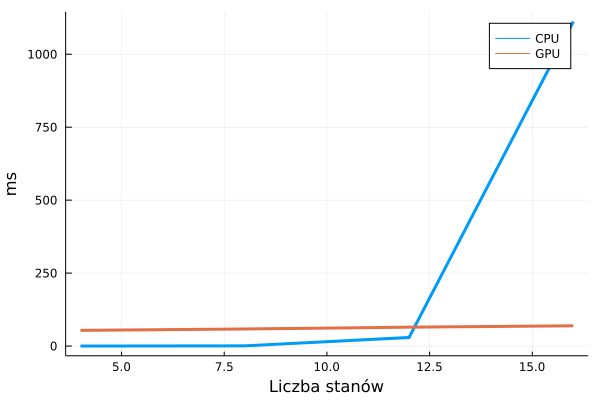

In [247]:
x = 1:10; y = rand(10); # These are the plotting data
plot(ns, [ct, gt], label = ["CPU" "GPU"], lw = 3)
xlabel!("Liczba spinów")
ylabel!("ms")

In [157]:
2^(16-4), (2^4), 2^(16-4)*(2^4)

(4096, 16, 0)

# Check kernel, index, block


In [210]:
# reverse(bitstring(2^64))
# bitstring(2^64-1)

# parseint(bitstring(10))

# for i in 1:12
#     println(bitstring(i))
# end

# bitstring(Int128, 2^128-1)

# typeof(2^128-1) 

# Int64(2^64)

# bitstring(Int128(2^129-2))

bitstring(UInt128(2^128)-2)

"11111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111110"

In [72]:
bitstring(2)

"0000000000000000000000000000000000000000000000000000000000000010"

In [6]:
const n = 2^20 # 1048576, number of elements in 1D arrays
const THREADS_PER_BLOCK = 256

# create a vector [0.0, 0.0, 0.0...], and send to GPU
C = zeros(Float32, n) |> cu 

# create two vectors, fill them with 1s and 2s, and send to GPU
A = fill(1.0f0, n) |> cu 
B = fill(2.0f0, n) |> cu

function add!(c, a, b)
    # compute the thread_id
    x = (blockIdx().x - 1) * blockDim().x + threadIdx().x 

    # i'th thread should get the i'th elements of a and b 
    # sum them, and then store them in i'th element of c
    @inbounds c[x] = a[x] + b[x]
    return
end

threads = THREADS_PER_BLOCK # 256
blocks = n ÷ threads # 4096

# launch the kernel with 4096 blocks, of 256 threads each
@cuda threads=threads blocks=blocks add!(C, A, B)

CUDA.HostKernel{add!, Tuple{CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}, CuDeviceVector{Float32, 1}}}(CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763), CuModule(Ptr{Nothing} @0x0000000006d8c800, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763)), CuFunction(Ptr{Nothing} @0x0000000003996590, CuModule(Ptr{Nothing} @0x0000000006d8c800, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763))))

In [7]:
x = zeros(Int8, 500, 20, 200)
# Initialize x
for c = 1:200
    for b = 1:20
        for a = 1:500
            x[a, b, c] = x[a, b, c] + 1
        end
    end
end

In [8]:
x = CUDA.zeros(3,5,7)

function kernel(x)
    a = blockIdx().x
    b = threadIdx().x
    c = threadIdx().y
    x[a, b, c] = a+b+c
    return
end

@cuda blocks=(3,4) threads=(5, 7) kernel(x)


CUDA.HostKernel{kernel, Tuple{CuDeviceArray{Float32, 3, 1}}}(CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763), CuModule(Ptr{Nothing} @0x00000000072bce90, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763)), CuFunction(Ptr{Nothing} @0x0000000007391ea0, CuModule(Ptr{Nothing} @0x00000000072bce90, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763))))

In [9]:
x

3×5×7 CuArray{Float32, 3}:
[:, :, 1] =
 3.0  4.0  5.0  6.0  7.0
 4.0  5.0  6.0  7.0  8.0
 5.0  6.0  7.0  8.0  9.0

[:, :, 2] =
 4.0  5.0  6.0  7.0   8.0
 5.0  6.0  7.0  8.0   9.0
 6.0  7.0  8.0  9.0  10.0

[:, :, 3] =
 5.0  6.0  7.0   8.0   9.0
 6.0  7.0  8.0   9.0  10.0
 7.0  8.0  9.0  10.0  11.0

[:, :, 4] =
 6.0  7.0   8.0   9.0  10.0
 7.0  8.0   9.0  10.0  11.0
 8.0  9.0  10.0  11.0  12.0

[:, :, 5] =
 7.0   8.0   9.0  10.0  11.0
 8.0   9.0  10.0  11.0  12.0
 9.0  10.0  11.0  12.0  13.0

[:, :, 6] =
  8.0   9.0  10.0  11.0  12.0
  9.0  10.0  11.0  12.0  13.0
 10.0  11.0  12.0  13.0  14.0

[:, :, 7] =
  9.0  10.0  11.0  12.0  13.0
 10.0  11.0  12.0  13.0  14.0
 11.0  12.0  13.0  14.0  15.0

In [231]:
a = CUDA.zeros(12)

function kernel(a)
    i = blockIdx().x
    a[i] = i
    return
end

@cuda blocks=(2,5) threads=(3,4,5) kernel(a)

CUDA.HostKernel{kernel, Tuple{CuDeviceVector{Float32, 1}}}(CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763), CuModule(Ptr{Nothing} @0x0000000008a8ab40, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763)), CuFunction(Ptr{Nothing} @0x0000000009618b50, CuModule(Ptr{Nothing} @0x0000000008a8ab40, CuContext(0x0000000003a69c00, instance 83630a2fe5c7f763))))

In [11]:
a

12-element CuArray{Float32, 1}:
 1.0
 2.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0